# Convergence at the leaves

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis
analysis.setup('spreadr_exp_1')

<module 'gists.models' from '/home/sl/Code/Research/interpretation-experiment/analysis/notebooks/exp_1/spreadr/gists/models.py'>

Imports for the analysis

In [3]:
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame, concat
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

## 2 Convergence at the leaves

### 2.1 leaf variability ~ root length

First define leaf variability for a tree

In [4]:
@memoized
def get_leaves(self):
    return [s for s in self.sentences.kept.all() if s.children.kept.count() == 0]

@memoized
def get_leaf_variability_detailed(self):
    return np.array([l1.oc_distance(l2)
                     for l1, l2 in combinations(self.leaves, 2)])

@memoized
def get_leaf_variability(self):
    return np.median(self.leaf_variability_detailed)

Tree.leaves = property(get_leaves)
Tree.leaf_variability_detailed = property(get_leaf_variability_detailed)
Tree.leaf_variability = property(get_leaf_variability)

Then generate our data

In [5]:
trees = Tree.objects.experiment.all()
data_trees = []
for tree in trees:
    lvd = tree.leaf_variability_detailed
    data_trees.append(DataFrame({'tree id': [tree.id] * len(lvd),
                                 'root length': [len(tree.root.content_words)] * len(lvd),
                                 'leaf pair separation': lvd}))
data = concat(data_trees)
data_m15 = data[data['root length'] < 15]
root_order = data.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])
root_order_m15 = data_m15.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])

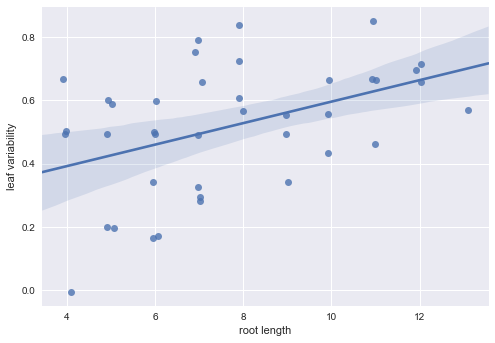

In [6]:
ax = sb.regplot(data_m15.groupby('tree id').median()['root length'],
                data_m15.groupby('tree id').median()['leaf pair separation'],
                x_jitter=.1, y_jitter=.01)
ax.set_ylabel('leaf variability')
if SAVE_FIGURES:
    ax.figure.savefig('/home/sl/Downloads/gistr/leaf-variability_root-length.png', dpi=300)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



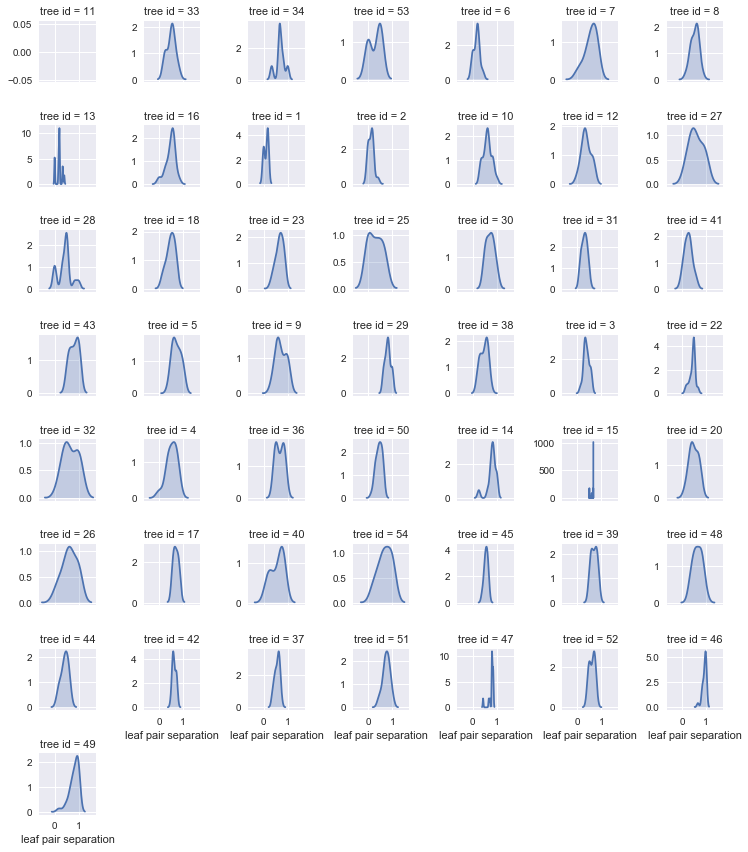

In [7]:
g = sb.FacetGrid(data=data, sharey=False,
                 col='tree id', col_wrap=7, size=1.5,
                 col_order=root_order['tree id'])
g.map(sb.kdeplot, 'leaf pair separation', shade=True)
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/leaf_distances_distributions.png', dpi=300)

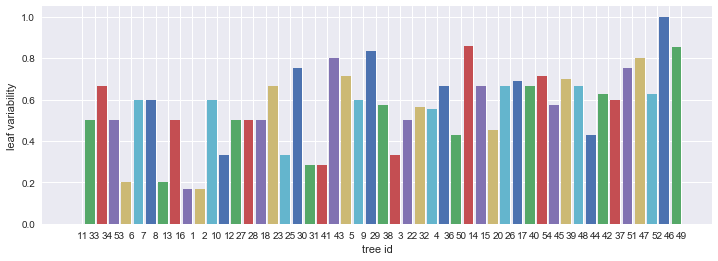

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
labels = []
bardata = data.groupby('tree id', as_index=False).median().sort_values(['root length',
                                                                        'tree id'])
for i, (separation, tree_id) in enumerate(zip(bardata['leaf pair separation'],
                                              bardata['tree id'])):
    ax.bar(i, separation)
    labels.append(tree_id)
trees_count = len(bardata)
ax.set_xticks(np.linspace(.4, trees_count + .4, trees_count, endpoint=False))
ax.set_xticklabels(labels)
ax.set_xlabel('tree id')
ax.set_ylabel('leaf variability')
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/leaf-variability_tree-id.png', dpi=300)

### 2.2 leaf variability ~ branch variability (= leaf cumulated transformation rate / leaf depth)

In [9]:
@memoized
def get_branches_variability(self):
    return np.array([leaf.cum_root_distance('oc') / leaf.depth
                     for leaf in self.leaves])

Tree.branches_variability = property(get_branches_variability)

In [10]:
trees = Tree.objects.experiment.all()
data_trees = []
for tree in trees:
    bvd = tree.branches_variability
    data_trees.append(DataFrame({'tree id': [tree.id] * len(bvd),
                                 'root length': [len(tree.root.content_words)] * len(bvd),
                                 'branches variability': bvd,
                                 'leaf variability': [tree.leaf_variability] * len(bvd)}))
data = concat(data_trees)
data_m15 = data[data['root length'] < 15]
root_order = data.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])
root_order_m15 = data_m15.groupby('tree id', as_index=False).mean().sort_values(\
    ['root length', 'tree id'])

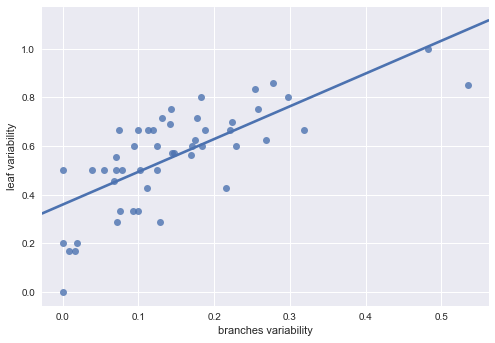

In [11]:
scatterdata = data.groupby('tree id', as_index=False).median()
sb.regplot(scatterdata['branches variability'], scatterdata['leaf variability'],
           robust=True, ci=None);

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars



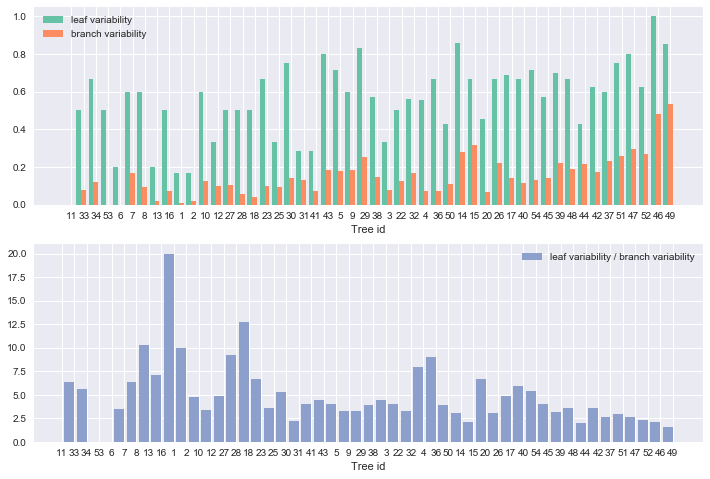

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
palette = sb.color_palette('Set2')
labels = []
bardata = data.groupby('tree id', as_index=False).median().sort_values(['root length',
                                                                        'tree id'])
for i, (lv, bv, tree_id) in enumerate(zip(bardata['leaf variability'], 
                                          bardata['branches variability'],
                                          bardata['tree id'])):
    axes[0].bar(i, lv, width=.4, color=palette[0],
                label='leaf variability' if i == 0 else None)
    axes[0].bar(i + .4, bv, width=.4, color=palette[1],
                label='branch variability' if i == 0 else None)
    axes[1].bar(i, lv/bv, color=palette[2],
                label='leaf variability / branch variability' if i == 0 else None)
    labels.append(tree_id)
trees_count = len(bardata)
axes[0].set_xticks(np.linspace(.4, trees_count + .4, trees_count, endpoint=False))
axes[0].set_xticklabels(labels)
axes[0].set_xlabel('Tree id')
axes[0].legend(loc='best')
axes[1].set_xticks(np.linspace(.4, trees_count + .4, trees_count, endpoint=False))
axes[1].set_xticklabels(labels)
axes[1].set_xlabel('Tree id')
axes[1].legend(loc='best')
if SAVE_FIGURES:
    fig.savefig('/home/sl/Downloads/gistr/divergence_rates.png', dpi=300)